# 4 Visualizing and analyzing cell metric data
This notebook shows how to
-  4.1 load libraries, predefined functions and the main dataset (skip if already done in a previous chapter)
-  4.2 visualize cell metrics in various ways 
-  4.3 create a smaller dataset by selecting cells (rows) from the main dataset
-  4.4 perform simple statistical analyses on these metric data

## 4.1 Load libraries, predefine some functions, and load the manifest 
*skip this if you already ran these in a previous Chapter*

### Load libraries and predefined functions

In [2]:
# First "pip install -e ." from command line (when in cytodata-hackathon-base)

import logging
logging.getLogger("bfio").setLevel(logging.ERROR)
logging.getLogger("bfio.backends").setLevel(logging.ERROR)
logging.getLogger("aicsimageio").setLevel(logging.ERROR)

from upath import UPath as Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nbvv

from serotiny.io.image import image_loader
from cytodata_aics.io_utils import rescale_image

### Load the manifest and explore dimensions

In [3]:
cells_df = pd.read_parquet("s3://variance-dataset/processed/manifest.parquet")
print(f'Number of cells: {len(cells_df)}')
print(f'Number of columns: {len(cells_df.columns)}')

Number of cells: 215081
Number of columns: 1242


## 4.2 Various plots of metrics in the dataset

### Make a bar plot of the number of cells per structure, stratified based on mitotic cell stage

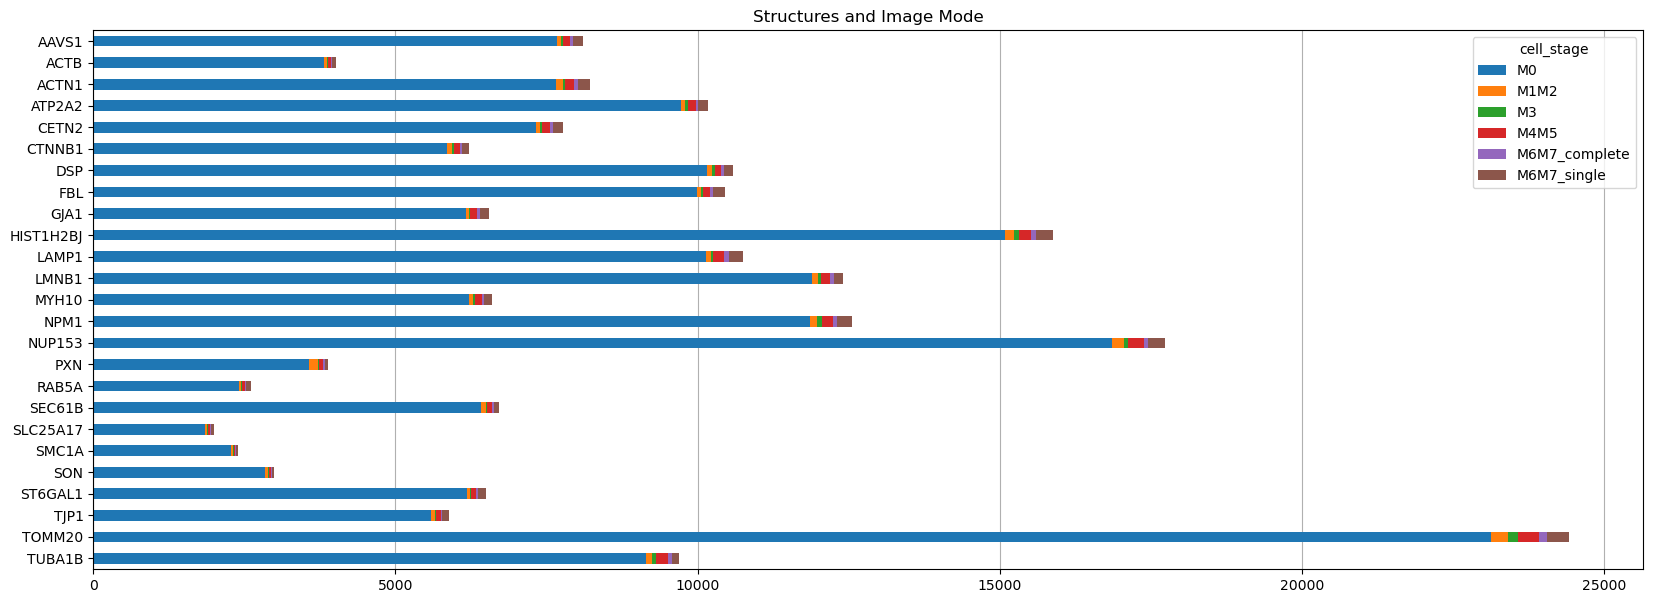

In [4]:
table = pd.pivot_table(cells_df, index="structure_name", columns="cell_stage", aggfunc="size")
fig, axes = plt.subplots(figsize=(20, 7), dpi=100)
table.plot.barh(stacked=True, ax=axes)
axes.set_ylabel(None)
axes.set_title("Structures and Image Mode")
axes.grid(True, which="major", axis="x")
axes.set_axisbelow(True)
axes.invert_yaxis()
plt.show()

### Plot a histogram for a metric

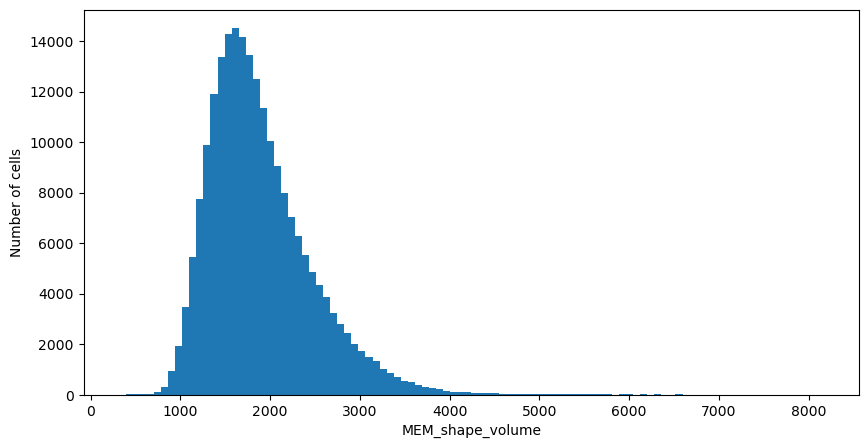

In [5]:
# select the metric (WE NEED MORE CLEAR LABELS THAN MEM_position_depth)
pix_size = 0.108  # micrometers per pixel for converting metrics

# metric = "MEM_position_depth"  # name of the metric column in the dataframe
# scl = pix_size**1  # convert pixels to micrometers (CONSIDER UPDATING DATASET TO USE MICROMETERS)

metric = "MEM_shape_volume"  # name of the metric column in the dataframe
scl = pix_size**3

fig, axes = plt.subplots(figsize=(10, 5), dpi=100)
axes.hist(cells_df[metric] * scl, bins=100)
axes.set_xlabel(metric)
axes.set_ylabel("Number of cells")
plt.show()

### Make a violin plot of a metric for various sub-populations

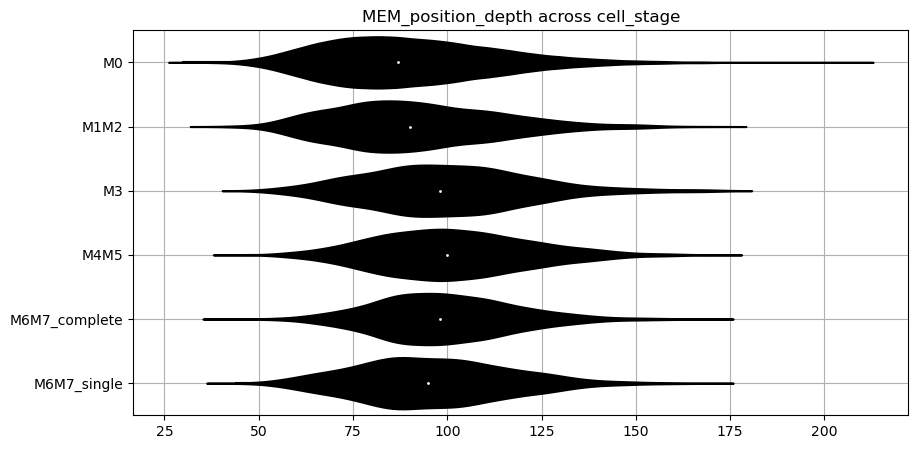

In [6]:
# select the metric (WE NEED MORE CLEAR LABELS THAN MEM_position_depth)
metric = "MEM_position_depth" #  metric to plot
stratifier = "cell_stage" #  name of column whose values are used to define sub-populations

order = np.sort(cells_df[stratifier].unique())
fig, axes = plt.subplots(figsize=(10, 5), dpi=100)
sns.violinplot(
    y=stratifier,
    x=metric,
    order = order,
    color="black",
    data=cells_df,
    scale="width",
    ax=axes
)

axes.set_title(f"{metric} across {stratifier}")
axes.grid(True, which="major", axis="both")
axes.set_axisbelow(True)
axes.set_ylabel(None)
axes.set_xlabel(None)

plt.show()

Note that cells in M6M7_single stage have smaller volumes than other cells. (MAYBE TRY TO VISUALIZE AND THEN DROP FROM DATASET)

### Create scatterplots to visualize correlation between metrics

#### Plot nuclear volume vs cell volume

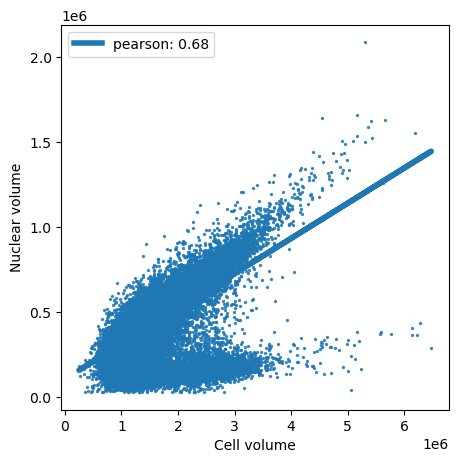

In [7]:
metric_x = cells_df["MEM_shape_volume"]  # Cell volume
metric_y = cells_df["NUC_shape_volume"]  # Nuclear volume

label_x = "Cell volume"
label_y = "Nuclear volume"

fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
linear_fit = np.polyfit(metric_x, metric_y, 1)  # calculate linear fit
predict_func = np.poly1d(linear_fit)  # create prediction function from linear fit
pearson_coeff = np.corrcoef(metric_x, metric_y)[0][1]  # calculate pearson correlation coefficient

ax.scatter(metric_x, metric_y, alpha=0.8, s=2)  # create scatter plot for nuclear volume vs cell volume
ax.plot(metric_x, predict_func(metric_x), linewidth=4,
        label="pearson: {:.2}".format(pearson_coeff))  # overlay linear fit

ax.set(xlabel=label_x, ylabel=label_y)
ax.legend()
plt.show()


The Pearson correlation coefficient for these metrics is fairly high, which re-iterates the nuclear size scaling principle.
However, there is a distinct sub-population of nuclei with smaller volumes even when the cell volume is high. 

#### Distinguishing sub-populations in the scatter plot

Note the cell cycle stages annotated within our dataset

In [8]:
print(np.sort(cells_df["cell_stage"].unique()))

['M0' 'M1M2' 'M3' 'M4M5' 'M6M7_complete' 'M6M7_single']


"M0" corresponds to cells in interphase, while the other entries correspond to various stages of mitosis. 

##### Create scatter plot with mitotic cells highlighted in a different color

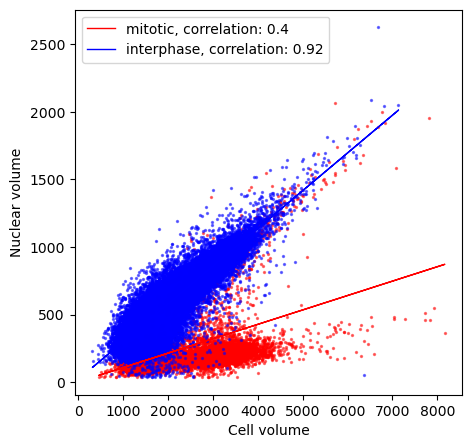

CPU times: user 2.03 s, sys: 705 ms, total: 2.74 s
Wall time: 2.47 s


In [20]:
%%time
interphase_stage = "M0"

scl = pix_size ** 3

mitotic_cell_volumes = cells_df[cells_df["cell_stage"] != interphase_stage]["MEM_shape_volume"]  # select volumes for mitotic cells
interphase_cell_volumes = cells_df[cells_df["cell_stage"] == interphase_stage]["MEM_shape_volume"]  # select volumes for interphase cells

mitotic_nucleus_volumes = cells_df[cells_df["cell_stage"] != interphase_stage]["NUC_shape_volume"]  # select volumes for mitotic nuclei
interphase_nucleus_volumes = cells_df[cells_df["cell_stage"] == interphase_stage]["NUC_shape_volume"]  # select volumes for interphase nuclei

metric_x1 = mitotic_cell_volumes * scl  # Cell volume for mitotic cells
metric_y1 = mitotic_nucleus_volumes * scl  # Nuclear volume for mitotic cells
label1 = "mitotic"

metric_x2 = interphase_cell_volumes * scl  # Cell volume for interphase cells
metric_y2 = interphase_nucleus_volumes * scl  # Nuclear volume for interphase cells
label2 = "interphase"

label_x = "Cell volume"
label_y = "Nuclear volume"

fig, ax = plt.subplots(figsize=(5, 5), dpi=100)

linear_fit1 = np.polyfit(metric_x1, metric_y1, 1)
pearson_coeff1 = np.corrcoef(metric_x1, metric_y1)[0][1]
predict_func1 = np.poly1d(linear_fit1)

linear_fit2 = np.polyfit(metric_x2, metric_y2, 1)
pearson_coeff2 = np.corrcoef(metric_x2, metric_y2)[0][1]
predict_func2 = np.poly1d(linear_fit2)

ax.scatter(metric_x1, metric_y1, alpha=0.5, s=2, c='r')
ax.plot(metric_x1, predict_func1(metric_x1), linewidth=1,
        label=f"{label1}, correlation: {pearson_coeff1:.2}", c='r')

ax.scatter(metric_x2, metric_y2, alpha=0.5, s=2, c='b')
ax.plot(metric_x2, predict_func2(metric_x2), linewidth=1,
        label=f"{label2}, correlation: {pearson_coeff2:.2}", c='b')

ax.set(xlabel=label_x, ylabel=label_y)
# ax.set_aspect('equal','box')
ax.legend()
plt.show()

The two sub-populations are clearly separated in the highlighted scatter plot. Note that the mitotic nuclei are much smaller than their interphase counterpart

## 4.3 Make a smaller dataset by selecting cells (rows) from the dataframe

### Select a subset of cells (1,000 edge cells and 1,000 non-edge cells) and plot some metrics for this subset

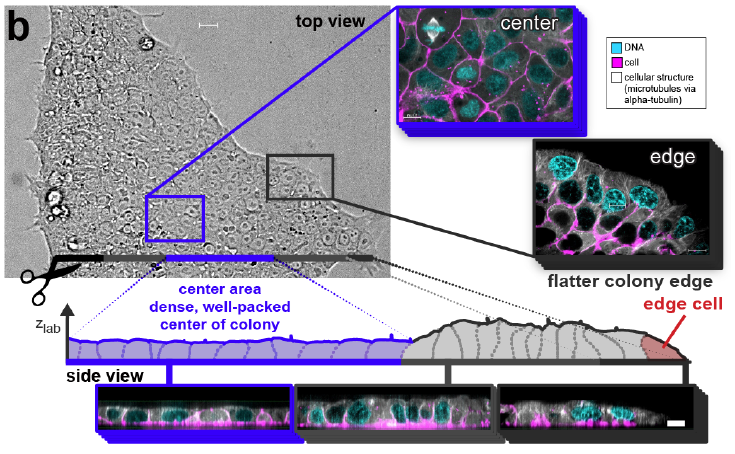 

Top and side views (single slice) of hiPSCs with FP-tagged microtubules (via alpha-tubulin), grown in tightly packed, epithelial-like colonies and labeled with cell membrane (magenta) and DNA (cyan) dyes to permit imaging and segmenting of cells and nuclei. Cells were most frequently imaged halfway towards the centers of large, well-packed colonies (blue) where they behave most consistently, but were also imaged at other locations within the colony, such as at the edges of colonies (red).

### Count number of edge and non-edge cells in the dataset

In [21]:
#count edge cells
num_edge = np.count_nonzero(cells_df["edge_flag"] == 1)
#count non-edge cells
num_non_edge = np.count_nonzero(cells_df["edge_flag"] == 0)
#print these numbers
print(f"Number of edge cells: {num_edge}, number of non-edge cells: {num_non_edge}")

# Note that this number is different from the number mentioned in the manuscript. Theo and Matheus can look into this.

Number of edge cells: 4316, number of non-edge cells: 210765


### Make a dataframe with same number of edge and non-edge cells

In [22]:
n = 1000 #number of cells per class
edge_label = cells_df["edge_flag"].unique() #labels (binary flag) associated with edge vs. non-edge calls

# Sample cells for each class and add to dataframe
index = pd.Series([])
for s, struct in enumerate(edge_label):
    index = index.append(
        cells_df[cells_df["edge_flag"] == s]
        .sample(n=n)
        .index.to_series()
    )
cells_edgeVSnoedge = cells_df.loc[index]
print(f'Number of cells: {len(cells_edgeVSnoedge)}')
print(f'Number of columns: {len(cells_edgeVSnoedge.columns)}')

/tmp/ipykernel_519/285784511.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  index = pd.Series([])


Number of cells: 2000
Number of columns: 1242


/tmp/ipykernel_519/285784511.py:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  index = index.append(
/tmp/ipykernel_519/285784511.py:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  index = index.append(


### Make a violinplot of a metric comparind edge vs. non-edge cells

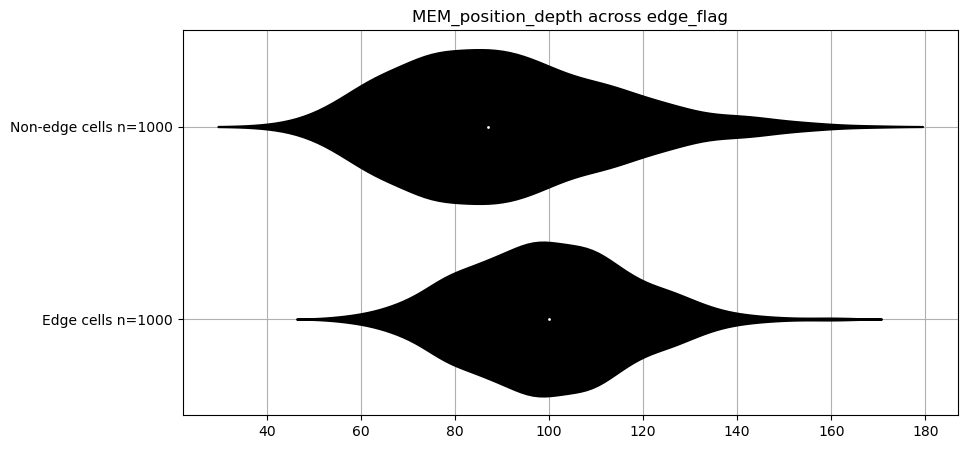

In [25]:
# make the edge_flag a categorical variable with is needed if we want to stratify on that variable
cells_edgeVSnoedge['edge_flag'] = cells_edgeVSnoedge.edge_flag.astype('category')
# select the metric (WE NEED MORE CLEAR LABELS THAN MEM_position_depth)
metric = "MEM_position_depth"
# select the variable to stratefy upon
stratifier = "edge_flag"
# select the order for the categories in the stratifier
order = np.sort(cells_edgeVSnoedge[stratifier].unique())
fig, axes = plt.subplots(figsize=(10, 5), dpi=100)
sns.violinplot(
    y=stratifier,
    x=metric,
    order = order,
    color="black",
    data=cells_edgeVSnoedge,
    scale="width",
    ax=axes
)

yticklabel = [f'Non-edge cells n={n}',f'Edge cells n={n}'] 

axes.set_title(f"{metric} across {stratifier}")
axes.grid(True, which="major", axis="both")
axes.set_axisbelow(True)
axes.set_ylabel(None)
axes.set_xlabel(None)
axes.set_yticklabels(yticklabel)
plt.show()

# Need to have more informative ytick-labels indicating edge (1) vs non-edge (0) cells

## 4.4 Perform simple statistical analyses on the metric data

### Do some statistical tests to see which feature shows the strongest difference between edge and non-edge cells

In [26]:
# Import t-test (test between means) and Kolmogorov-Smirnov test (test comparing entire distributions)
from scipy.stats import ttest_ind,kstest

# Select features to test
selected_features = ['NUC_shape_volume','NUC_position_depth','NUC_roundness_surface_area','MEM_shape_volume','MEM_position_depth','MEM_roundness_surface_area',\
                     'NUC_MEM_PC1','NUC_MEM_PC2','NUC_MEM_PC3','NUC_MEM_PC4','NUC_MEM_PC5','NUC_MEM_PC6','NUC_MEM_PC7','NUC_MEM_PC8']

# Create two groups (edge cells and non-edge cells)
edge_cells = cells_edgeVSnoedge[cells_edgeVSnoedge['edge_flag']==1]
noedge_cells = cells_edgeVSnoedge[cells_edgeVSnoedge['edge_flag']==0]

# Perform t-test, save t-scores and associated p-values
t_scores = np.empty([len(selected_features),1])
t_pvalues = np.empty([len(selected_features),1])
for i,feature in enumerate(selected_features):
    t_scores[i],t_pvalues[i] = ttest_ind(edge_cells[feature].dropna(), noedge_cells[feature].dropna())
# print(t_scores)

# Perform ks-test, save ks-scores and associated p-values
ks_scores = np.empty([len(selected_features),1])
ks_pvalues = np.empty([len(selected_features),1])
for i,feature in enumerate(selected_features):
    ks_scores[i],ks_pvalues[i] = kstest(edge_cells[feature].dropna(), noedge_cells[feature].dropna())
# print(ks_scores)

#### Make plot with test statistics (or associated p-values)

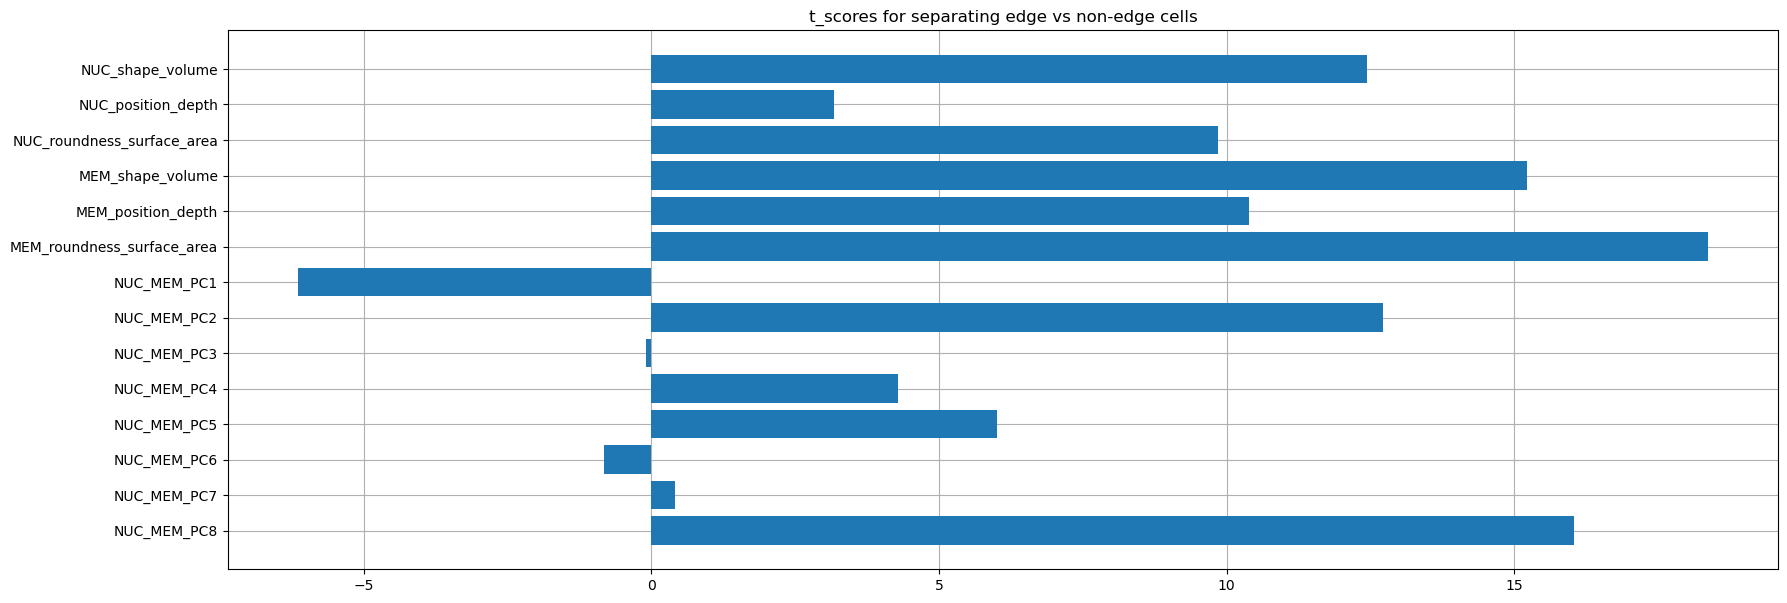

In [27]:
fig, axes = plt.subplots(figsize=(20, 7), dpi=100)

# select which score to plot
plt.barh(y = selected_features, width = t_scores.squeeze())
# plt.barh(y = selected_features, width = -np.log10(ks_pvalues.squeeze()))

axes.set_ylabel(None)
axes.set_title("t_scores for separating edge vs non-edge cells")
axes.grid(True, which="major", axis="both")
axes.set_axisbelow(True)
axes.invert_yaxis()
plt.show()

### Build simple classifier (Random Forest out of the box) to discriminate between edge and non-edge cells



In [30]:
# Import RF classifier and confusion matrix functionality
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

# Initialize classifer
clf = RandomForestClassifier(max_depth=2, random_state=0)

# Make the dataset (features matrix X and class labels y)
Xy = cells_edgeVSnoedge[[*selected_features, 'edge_flag']].dropna(axis=0).to_numpy()
X = Xy[:,0:-1]
y = Xy[:,-1]
print(Xy.shape,X.shape,y.shape)

# Fit the model
clf.fit(X, y)
# Apply the model (to the training dataset)
y_pred = clf.predict(X)
# Show performance as a confusion matrix
cm = confusion_matrix(y, y_pred)                        

(1518, 15) (1518, 14) (1518,)


### Visualize the confusion matrix

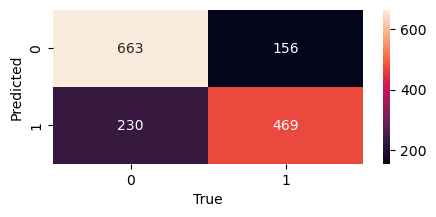

In [40]:
cm_df = pd.DataFrame(cm)
fig, axes = plt.subplots(figsize=(5, 2), dpi=100)
sns.heatmap(cm_df, annot=True, fmt='d')
axes.set_xlabel('True')
axes.set_ylabel('Predicted')
plt.show()

### Look at the importance scores

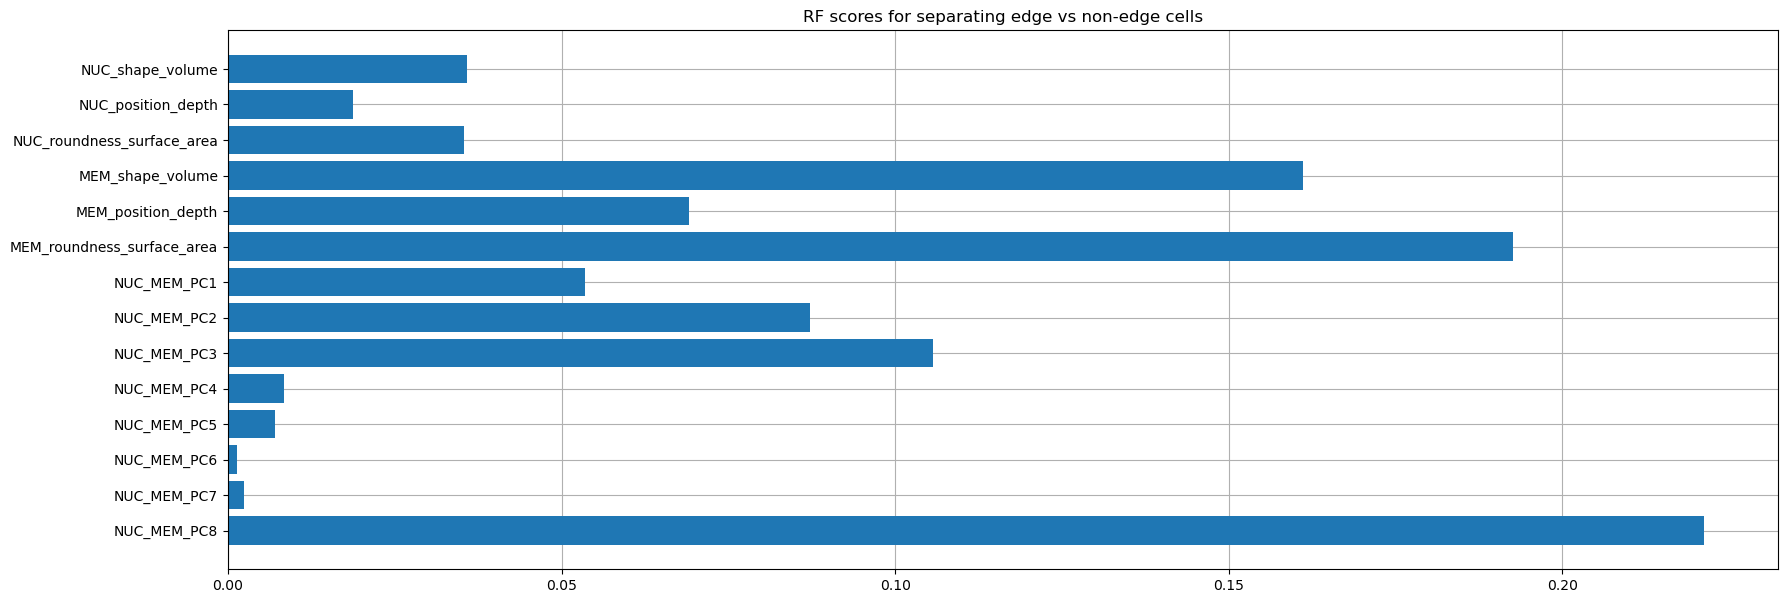

In [41]:
importances = clf.feature_importances_
fig, axes = plt.subplots(figsize=(20, 7), dpi=100)
plt.barh(y = selected_features, width = importances.squeeze())
axes.set_ylabel(None)
axes.set_title("RF scores for separating edge vs non-edge cells")
axes.grid(True, which="major", axis="both")
axes.set_axisbelow(True)
axes.invert_yaxis()
plt.show()